# Homework 2

In [1]:
!curl https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv >> data/data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1390k  100 1390k    0     0  2355k      0 --:--:-- --:--:-- --:--:-- 2364k


In [27]:
import pandas as pd
import seaborn as sns
import numpy as np

In [45]:
df = pd.read_csv('data/data.csv')

In [29]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

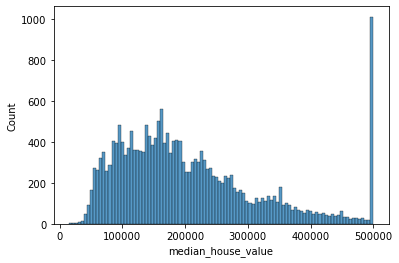

In [30]:
sns.histplot(data=df, x='median_house_value', bins=100)

You could consider this a long tail.

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

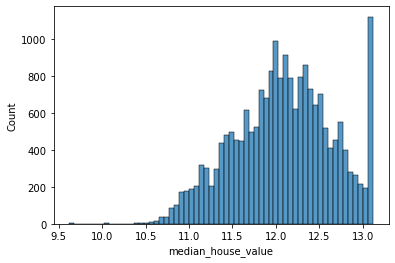

In [31]:
log_val = np.log1p(df.median_house_value)
sns.histplot(log_val)

In [32]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [33]:
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
df = df[features]

In [34]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


## Question 1

In [35]:
df.isnull().sum()[df.isnull().sum() > 0]

total_bedrooms    207
dtype: int64

## Question 2

In [36]:
df.population.median()

1166.0

## Question 3

In [114]:

def get_split_indices(f_val, f_test, n_rows):
    
    n_val = int(f_val * n_rows)
    n_test = int(f_test * n_rows)
    n_train = n_rows - n_val - n_test
    
    return n_train, n_val, n_test


def shuffle_idx(df, seed):
    
    np.random.seed(seed)
    idx = np.arange(len(df.index))
    np.random.shuffle(idx)

    return idx
      

def split(df, log=False, seed=42):
    df = df.copy()
    
    features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
    df = df[features]

    idx = shuffle_idx(df, seed=seed)
    
    n_train, n_val, n_test = get_split_indices(0.2, 0.2, len(df.index))

    df_train = df.iloc[idx[:n_train]].reset_index(drop=True)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=True)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=True)

    y_train = df_train.median_house_value.values
    y_val = df_val.median_house_value.values
    y_test = df_test.median_house_value.values
    
    if log:
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        y_test = np.log1p(y_test)
        
    del df_train['median_house_value']
    del df_val['median_house_value']
    del df_test['median_house_value']
        
    return df_train, df_val, df_test, y_train, y_val, y_test
    

In [115]:
df_train, df_val, df_test, y_train, y_val, y_test = split(df, log=True)

In [116]:
def fill_missing_values(df_train, df_val, df_test, how):
    
    feature = 'total_bedrooms'
    
    if how == 'mean':
        new_val = df_train[feature].mean()
    elif how == 'zero':
        new_val = 0
    
    df_train[feature] = df_train[feature].fillna(new_val)
    df_val[feature] = df_val[feature].fillna(new_val)
    df_test[feature] = df_test[feature].fillna(new_val)
    
    return df_train, df_val, df_test
    

In [117]:
# From https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/02-regression/notebook.ipynb


def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [118]:
df = pd.read_csv('data/data.csv')
df_train, df_val, df_test, y_train, y_val, y_test = split(df, log=True)
df_train, df_val, df_test = fill_missing_values(df_train, df_val, df_test, 'mean')

bias, weights = train_linear_regression_reg(df_train.values, y_train, r=0)
preds_val = bias + df_val.values.dot(weights)
print(f'RMSE mean replaced missing values: \t{round(rmse(y_val, preds_val), 2)}')

df = pd.read_csv('data/data.csv')
df_train, df_val, df_test, y_train, y_val, y_test = split(df, log=True)
df_train, df_val, df_test = fill_missing_values(df_train, df_val, df_test, 'zero')

bias, weights = train_linear_regression_reg(df_train.values, y_train, r=0)
preds_val = bias + df_val.values.dot(weights)
print(f'RMSE zero replaced missing values: \t{round(rmse(y_val, preds_val), 2)}')


RMSE mean replaced missing values: 	0.33
RMSE zero replaced missing values: 	0.33


Conclusion: both options are equally good.

## Question 4

In [119]:
r_values = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

df = pd.read_csv('data/data.csv')
df_train, df_val, df_test, y_train, y_val, y_test = split(df, log=True)
df_train, df_val, df_test = fill_missing_values(df_train, df_val, df_test, 'zero')

for r in r_values:
    bias, weights = train_linear_regression_reg(df_train.values, y_train, r=r)
    preds_val = bias + df_val.values.dot(weights)
    print(f'RMSE: {round(rmse(y_val, preds_val), 2)}, r={r}')

RMSE: 0.33, r=0
RMSE: 0.33, r=1e-06
RMSE: 0.33, r=0.0001
RMSE: 0.33, r=0.001
RMSE: 0.33, r=0.01
RMSE: 0.33, r=0.1
RMSE: 0.33, r=1
RMSE: 0.34, r=5
RMSE: 0.34, r=10


Smallest rmse and r: 1e-06

## Question 5

In [122]:
seeds = np.arange(10)

scores = []

for seed in seeds:
    df = pd.read_csv('data/data.csv')
    df_train, df_val, df_test, y_train, y_val, y_test = split(df, log=True, seed=seed)
    df_train, df_val, df_test = fill_missing_values(df_train, df_val, df_test, 'zero')

    bias, weights = train_linear_regression_reg(df_train.values, y_train, r=0)
    preds_val = bias + df_val.values.dot(weights)
    
    score = round(rmse(y_val, preds_val), 2)
    print(f'RMSE: {score}, seed={seed}')
    scores.append(score)
                   
print(f'RMSE standard deviation: {round(np.std(scores), 3)}')

RMSE: 0.34, seed=0
RMSE: 0.34, seed=1
RMSE: 0.33, seed=2
RMSE: 0.34, seed=3
RMSE: 0.34, seed=4
RMSE: 0.34, seed=5
RMSE: 0.35, seed=6
RMSE: 0.34, seed=7
RMSE: 0.35, seed=8
RMSE: 0.34, seed=9
RMSE standard deviation: 0.005


## Question 6

In [124]:
r = 0.001
seed = 9

df = pd.read_csv('data/data.csv')
df_train, df_val, df_test, y_train, y_val, y_test = split(df, log=True, seed=seed)
df_train, df_val, df_test = fill_missing_values(df_train, df_val, df_test, 'zero')

df_train_full = pd.concat([df_train, df_val])
y_train_full = np.concatenate([y_train, y_val])

bias, weights = train_linear_regression_reg(df_train_full.values, y_train_full, r=r)
preds_test = bias + df_test.values.dot(weights)

score = round(rmse(y_test, preds_test), 2)
print(f'Trained on train + val, RMSE: {score}, seed={seed}, r={r}')

Trained on train + val, RMSE: 0.35, seed=9, r=0.001
